In [101]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from env.area import Area

# Set seaborn theme globally
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)


def plot_histograms(projects, area_pickle_file):
    contributors_per_project(projects)
    success_rate_over_time(projects)
    quality_metrics_over_time(projects)
    collab_metrics_over_time(projects)
    projects_per_contributor(projects)
    # prestige_per_project(projects)
    completion_per_project(projects)
    quality_per_project(projects)
    topic_area_per_project(projects, area_pickle_file)


def contributors_per_project(projects):
    num_contributors = [len(p["contributors"]) for p in projects]

    plt.figure(figsize=(8, 5))
    sns.histplot(num_contributors, bins=range(1, max(num_contributors) + 2), kde=False, discrete=True)
    plt.xlabel("Number of Contributors")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Contributors per Project")
    plt.tight_layout()
    plt.show()


def projects_per_contributor(projects):
    all_contributors = []
    for p in projects:
        all_contributors.extend(p["contributors"])

    author_counts = Counter(all_contributors)
    papers_per_author = list(author_counts.values())

    plt.figure(figsize=(8, 5))
    sns.histplot(papers_per_author, bins=range(1, max(papers_per_author) + 2), kde=False, discrete=True)
    plt.xlabel("Number of Papers per Author")
    plt.ylabel("Number of Authors")
    plt.title("Authors by Number of Papers")
    plt.tight_layout()
    plt.show()


def prestige_per_project(projects):
    prestige_categories = [int(p["project_id"].split("-")[1]) % 3 for p in projects]

    plt.figure(figsize=(6, 4))
    sns.histplot(prestige_categories, bins=range(1, max(prestige_categories)), kde=False, discrete=True)
    plt.xlabel("Prestige Category (mod 3)")
    plt.ylabel("Number of Projects")
    plt.title("Projects per Prestige Category")
    plt.tight_layout()
    plt.show()


def completion_per_project(projects):
    completion = [max(0, p["current_effort"] / p["required_effort"]) * 100 for p in projects]
    plt.figure(figsize=(8, 5))
    sns.histplot(completion, bins=range(0, 110, 10), kde=False, discrete=True)
    plt.xlabel("Completion (%)")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Project Completion")
    plt.tight_layout()
    plt.show()


def quality_per_project(projects):
    quality_scores = [p["quality_score"] for p in projects]

    plt.figure(figsize=(8, 5))
    sns.histplot(quality_scores, bins=[i/10 for i in range(0, 11)], kde=False)
    plt.xlabel("Quality Score")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Project Quality Scores")
    plt.tight_layout()
    plt.show()

def success_rate_over_time(projects):
    """
    Plots the cumulative success rate of projects (finished / started)
    over time, using 'start_time' and 'finished' from the projects list.
    """
    # Extract (start_time, finished) for each project
    events = [(p["start_time"], p["finished"], p["final_reward"]) for p in projects]

    # Sort by start time
    events.sort(key=lambda x: x[0])

    time_steps = []
    success_rates = []

    finished = 0
    successful = 0

    for t, is_finished, score in events:
        if is_finished:
            finished += 1
            if score > 0:
                successful += 1
        success_rate = successful/ finished if finished > 0 else 0
        time_steps.append(t)
        success_rates.append(success_rate)

    # Plot
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=time_steps, y=success_rates)
    plt.xlabel("Time Step")
    plt.ylabel("Success Rate")
    plt.title("Project Success Rate Over Time")
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

def quality_metrics_over_time(projects):
    """
    Plots quality score, number of citations, current effort,
    and novelty over project start_time in one line plot.
    """
    # Sort projects by start time
    projects_per_time = {p["start_time"]:[] for p in projects}
    for p in projects:
        projects_per_time[p["start_time"]].append(p)
    projects_sorted = sorted(projects_per_time.items(), key=lambda p: p[0])

    times = [t for t, p in projects_sorted]
    quality = [np.mean([p["quality_score"] for p in pjs]) for _ ,pjs in projects_sorted]
    novelty = [np.mean([p["novelty_score"] for p in pjs]) for _ ,pjs in projects_sorted]
    value = [np.mean([p["societal_value_score"] for p in pjs]) for _, pjs in projects_sorted]

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=times, y=quality, label="Quality Score")
    sns.lineplot(x=times, y=novelty, label="Novelty")
    sns.lineplot(x=times, y=value, label="Societal Value")

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Project Metrics Over Time")
    plt.legend()
    # plt.tight_layout()
    plt.show()

def collab_metrics_over_time(projects):
    """
    Plots quality score, number of citations, current effort,
    and novelty over project start_time in three side-by-side plots.
    """
    # Sort projects by start time
    projects_per_time = {p["start_time"]: [] for p in projects}
    for p in projects:
        projects_per_time[p["start_time"]].append(p)
    projects_sorted = sorted(projects_per_time.items(), key=lambda p: p[0])

    times = [t for t, _ in projects_sorted]
    effort = [np.mean([p["current_effort"] for p in pjs]) for _, pjs in projects_sorted]
    n_contributors = [np.mean([len(p["contributors"]) for p in pjs]) for _, pjs in projects_sorted]
    citations = [np.sum([len(p["citations"]) for p in pjs]) for _, pjs in projects_sorted]

    # Create 1 row, 3 column subplot layout
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    # Plot effort
    sns.lineplot(x=times, y=effort, ax=axes[0])
    axes[0].set_title("Current Effort")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Effort")

    # Plot contributors
    sns.lineplot(x=times, y=n_contributors, ax=axes[1])
    axes[1].set_title("# Contributors per Paper")
    axes[1].set_xlabel("Time Step")
    axes[1].set_ylabel("# Contributors")

    # Plot citations
    sns.lineplot(x=times, y=citations, ax=axes[2])
    axes[2].set_title("Citations")
    axes[2].set_xlabel("Time Step")
    axes[2].set_ylabel("Citations")

    plt.tight_layout()
    plt.show()



def topic_area_per_project(projects, area_pickle_file):
    area = Area.load(area_pickle_file)
    area.visualize(sampled_points=[p["kene"] for p in projects])

def visualize_policy_population_proportion(simulation_steps):
    """
    Given a list of dictionaries representing steps in the simulation,
    count the occurrences of each 'archetype' per step and visualize 
    their proportions over time as a stacked area chart.
    """
    # Collect archetype counts per step
    records = []
    for step_idx, step in enumerate(simulation_steps):
        for agent in step.values():  # assume step is a list of agent dicts
            if agent is not None:
                records.append({
                    "step": step_idx,
                    "archetype": agent["archetype"]
                })

    df = pd.DataFrame(records)

    # Count archetypes per step
    counts = df.groupby(["step", "archetype"]).size().reset_index(name="count")

    # Pivot to wide format (steps × archetypes)
    pivot = counts.pivot(index="step", columns="archetype", values="count").fillna(0)

    # Normalize to proportions
    proportions = pivot.div(pivot.sum(axis=1), axis=0)

    # Plot stacked area chart
    plt.figure()
    proportions.plot.area(colormap="tab20", alpha=0.85, figsize=(12, 8))

    plt.title("Archetype Proportions Over Simulation Steps")
    plt.xlabel("Step")
    plt.ylabel("Proportion")
    plt.legend(title="Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

def visualize_policy_population(simulation_steps):
    """
    Given a list of dictionaries representing steps in the simulation,
    count the occurrences of each 'archetype' per step and visualize 
    their absolute counts over time as a line plot.
    Also shows the total number of agents per step in a smaller panel underneath.
    """
    # Collect archetype counts per step
    records = []
    for step_idx, step in enumerate(simulation_steps):
        for agent in step.values():  # assume step is a dict of agents
            if agent is not None:
                records.append({
                    "step": step_idx,
                    "archetype": agent["archetype"]
                })

    df = pd.DataFrame(records)

    # Count archetypes per step
    counts = df.groupby(["step", "archetype"]).size().reset_index(name="count")

    # Pivot to wide format (steps × archetypes)
    pivot = counts.pivot(index="step", columns="archetype", values="count").fillna(0)

    # Compute total per step
    total_counts = pivot.sum(axis=1)

    # Two subplots: main plot + smaller panel underneath
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Top: archetype counts
    pivot.plot.line(ax=axes[0])
    axes[0].set_title("Archetype Counts Over Simulation Steps")
    axes[0].set_ylabel("Count")
    axes[0].legend(title="Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Bottom: total counts
    total_counts.plot(ax=axes[1], color="black")
    axes[1].set_title("Total Agents")
    axes[1].set_xlabel("Step")
    axes[1].set_ylabel("Total Count")

    plt.tight_layout()
    plt.show()

In [89]:
# Load projects list from JSON file
with open("../log/policy_all_careerist_projects.json", "r") as f:
    all_careerist_projects = json.load(f)


In [ ]:
plot_histograms(all_careerist_projects, "../log/policy_all_careerist_area.pickle")

In [77]:
# Load projects list from JSON file
with open("../log/policy_all_orthodox_projects.json", "r") as f:
    all_orthodox_projects = json.load(f)

In [ ]:
plot_histograms(all_orthodox_projects, "../log/policy_all_orthodox_area.pickle")

In [119]:

    # Load projects list from JSON file
with open("../log/policy_all_mass_producer_projects.json", "r") as f:
    all_mass_producer_projects = json.load(f)
with open("../log/policy_all_mass_producer_actions.jsonl", "r") as f:
    all_mass_producer_actions = []
    for line in f.readlines():
        all_mass_producer_actions.append(json.loads(line))

<Figure size 640x480 with 0 Axes>

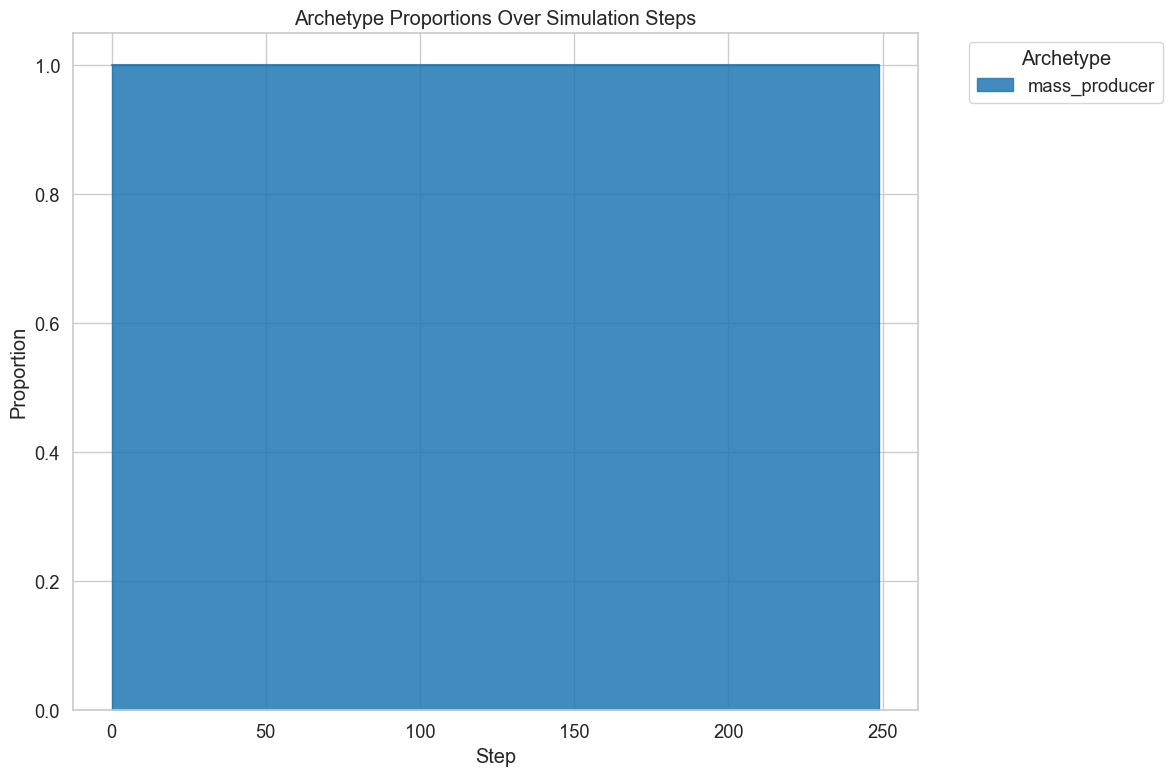

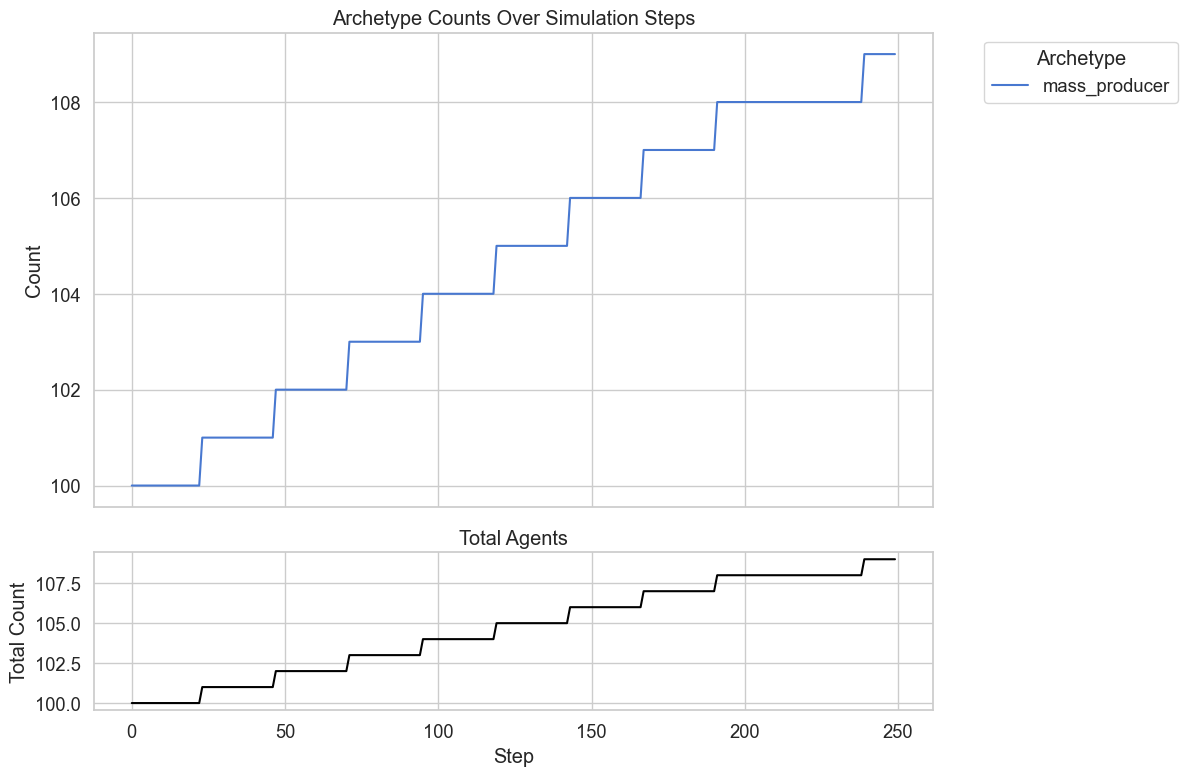

In [120]:
visualize_policy_population_proportion(all_mass_producer_actions)
visualize_policy_population(all_mass_producer_actions)

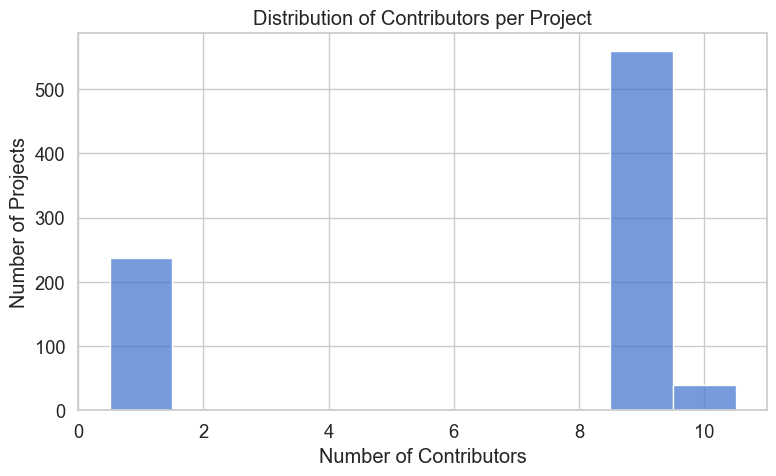

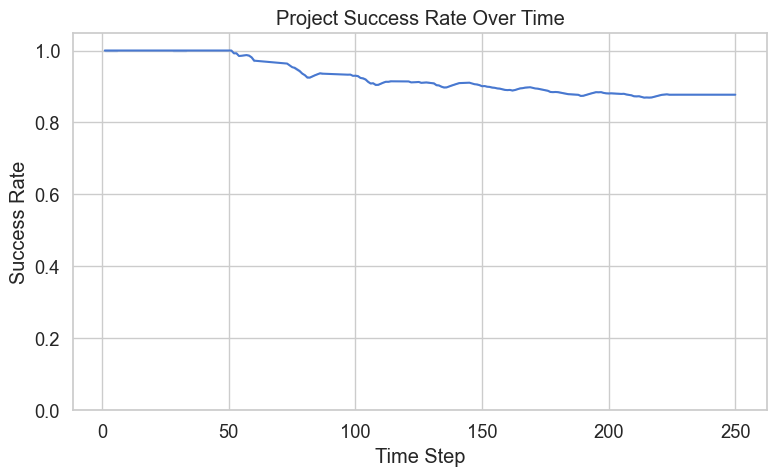

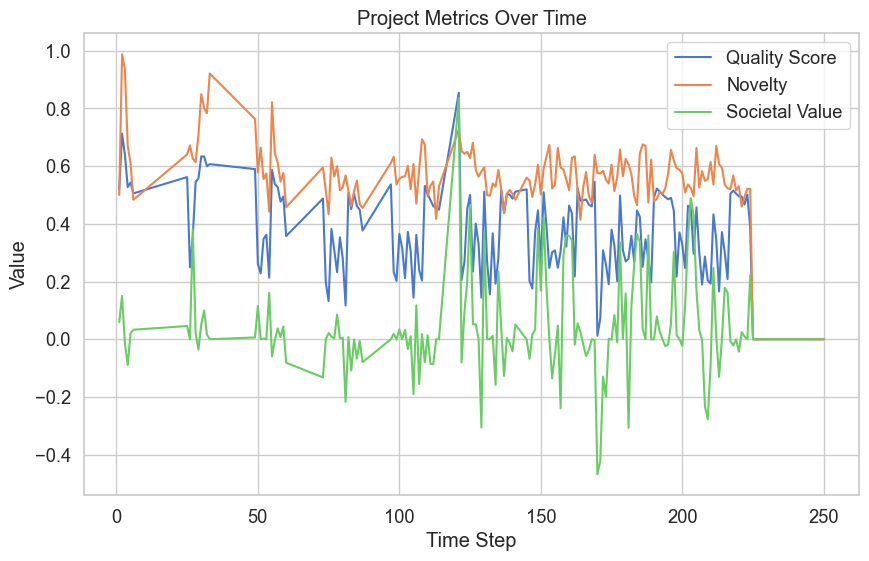

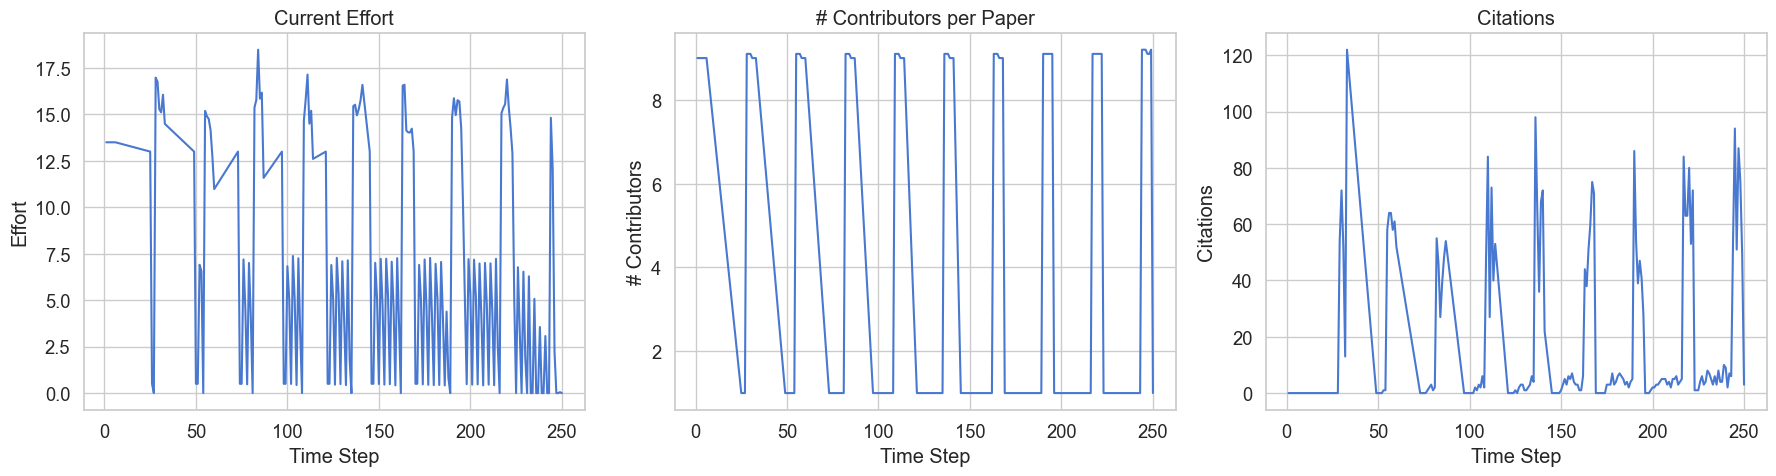

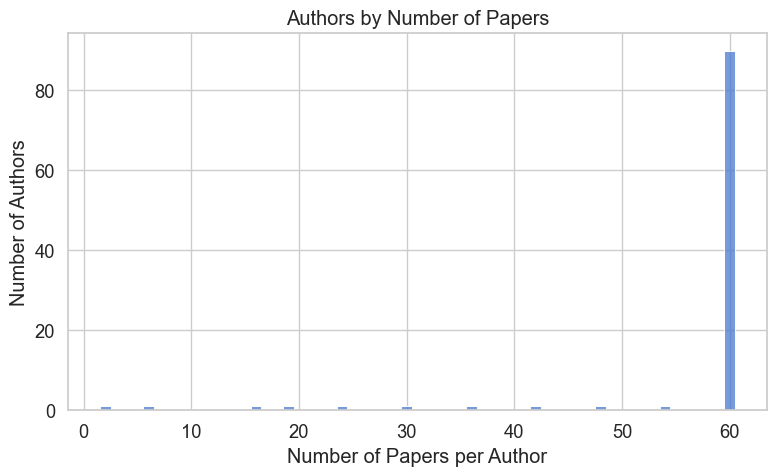

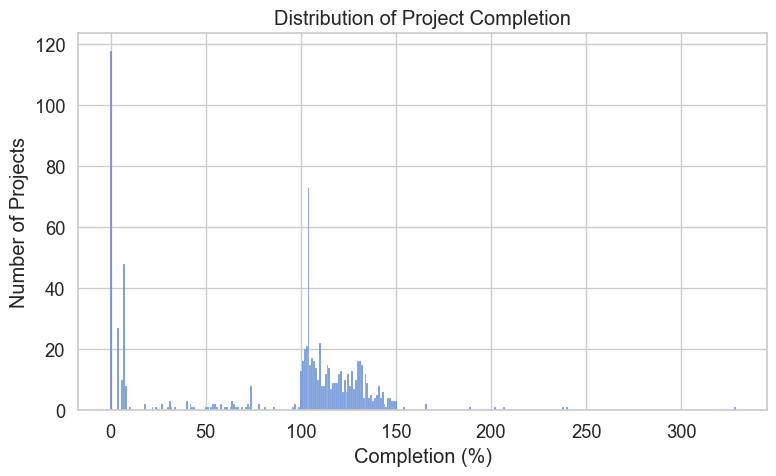

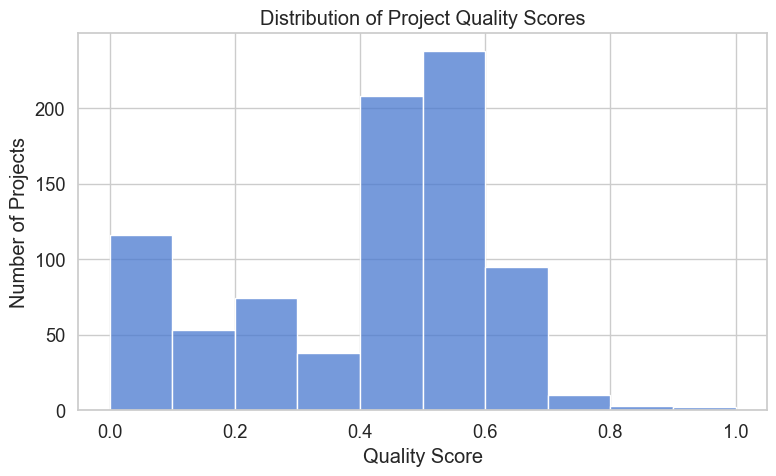

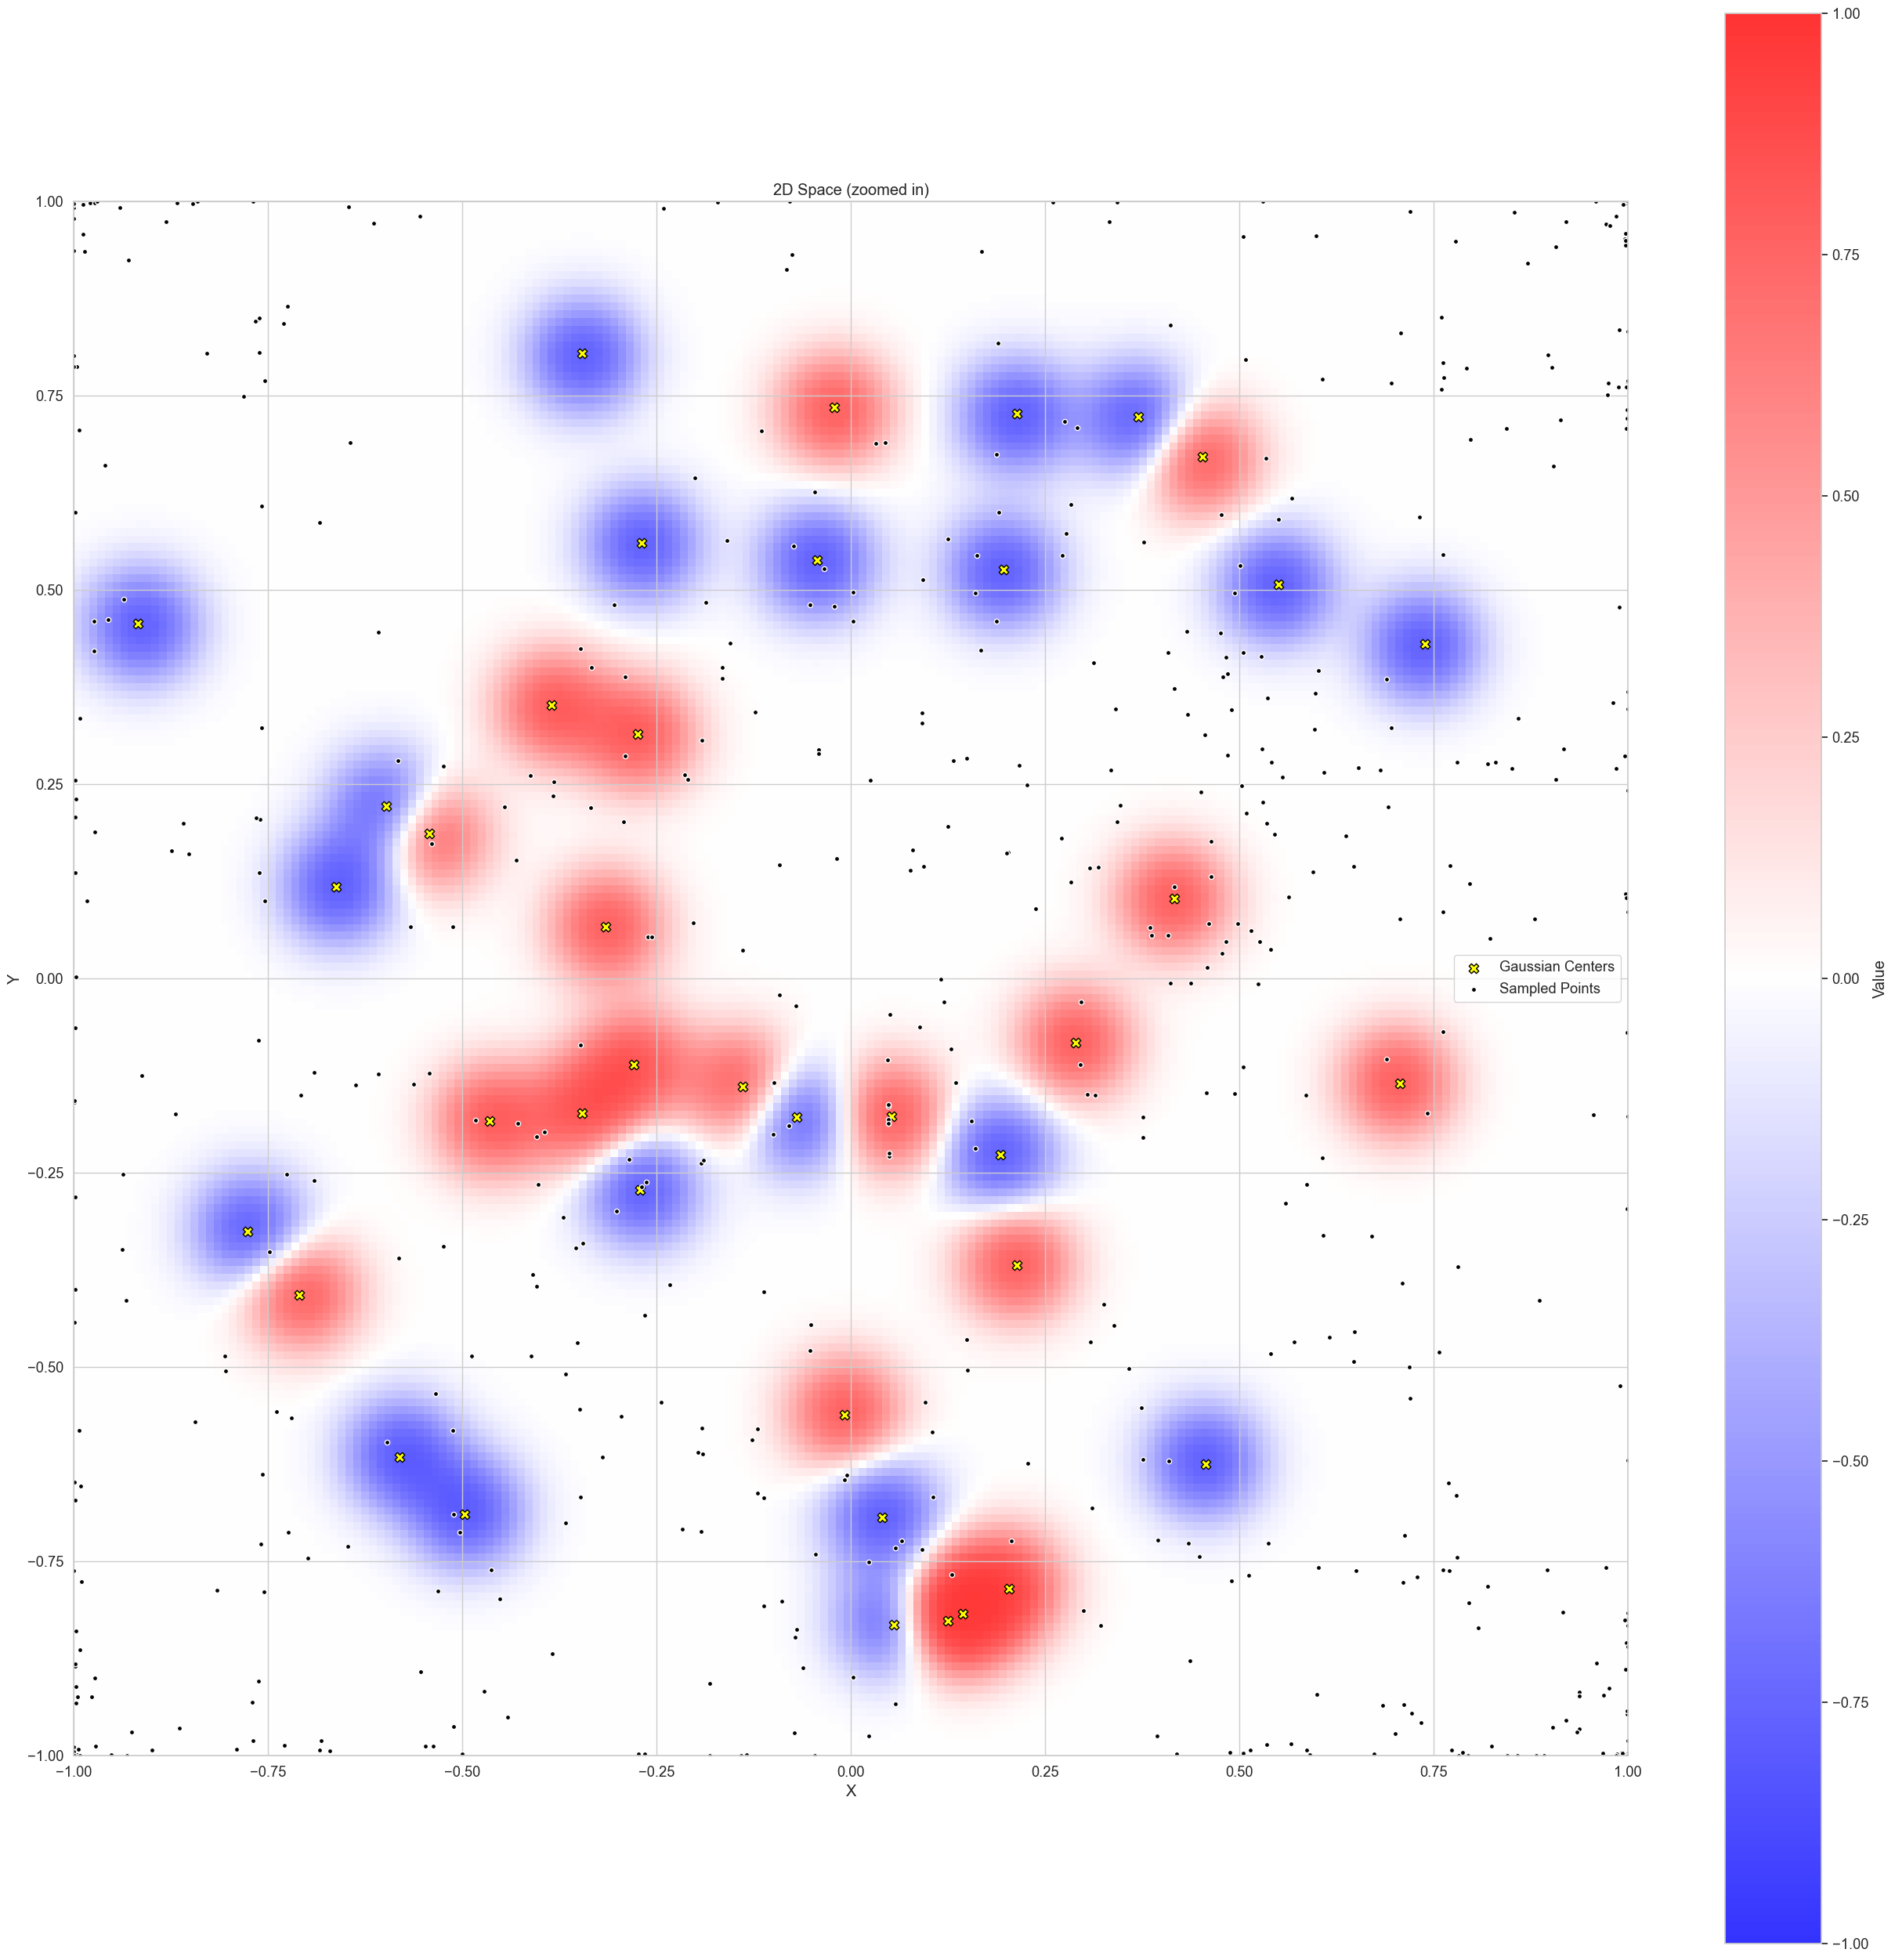

In [121]:
plot_histograms(all_mass_producer_projects, "../log/policy_all_mass_producer_area.pickle")

In [131]:

# Load projects list from JSON file
with open("../log/balanced_projects.json", "r") as f:
    balanced_projects = json.load(f)
with open("../log/balanced_actions.jsonl", "r") as f:
    balanced_actions = []
    for line in f.readlines():
        balanced_actions.append(json.loads(line))

<Figure size 640x480 with 0 Axes>

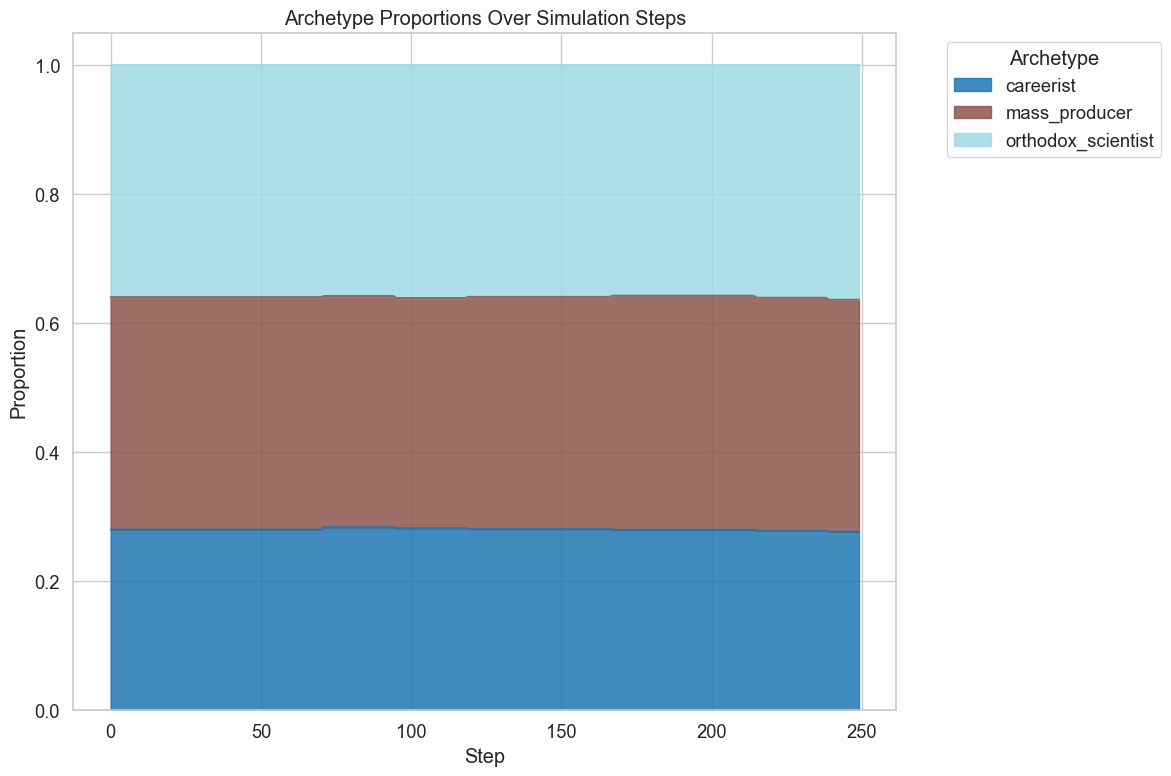

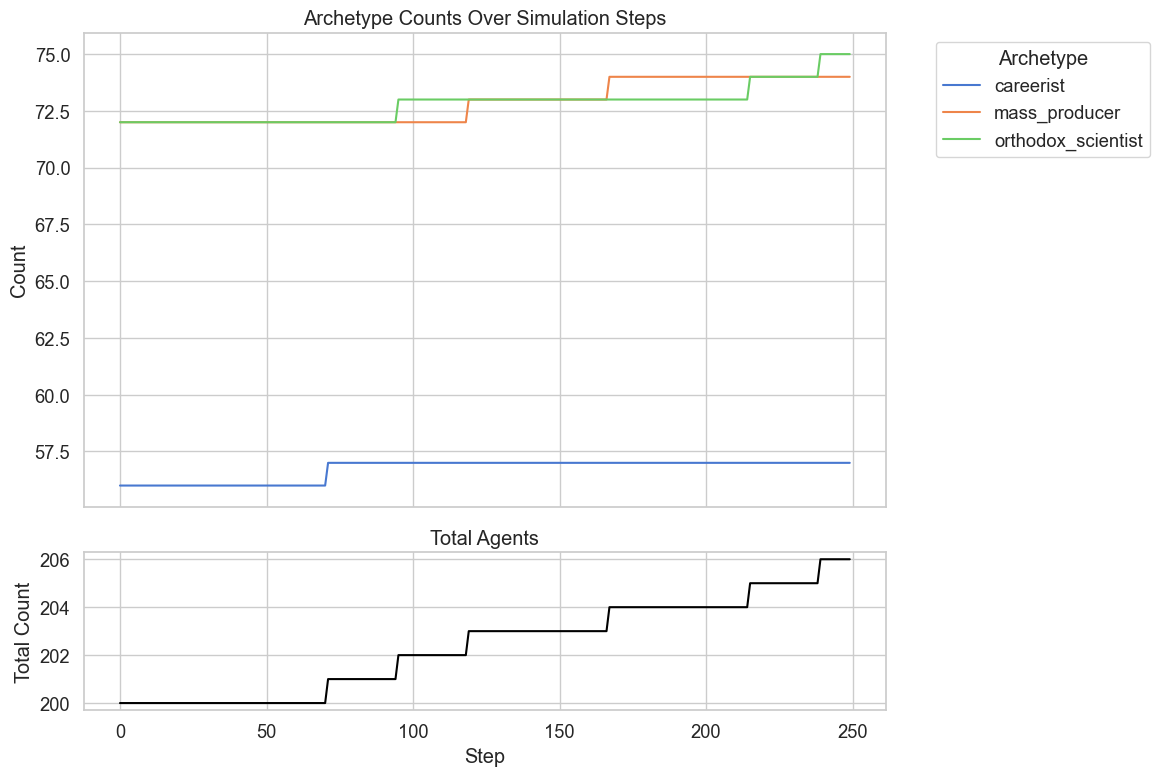

In [132]:
visualize_policy_population_proportion(balanced_actions)
visualize_policy_population(balanced_actions)


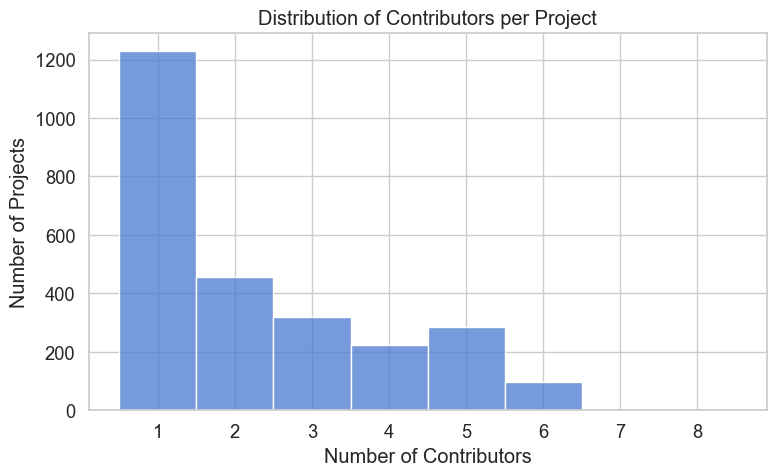

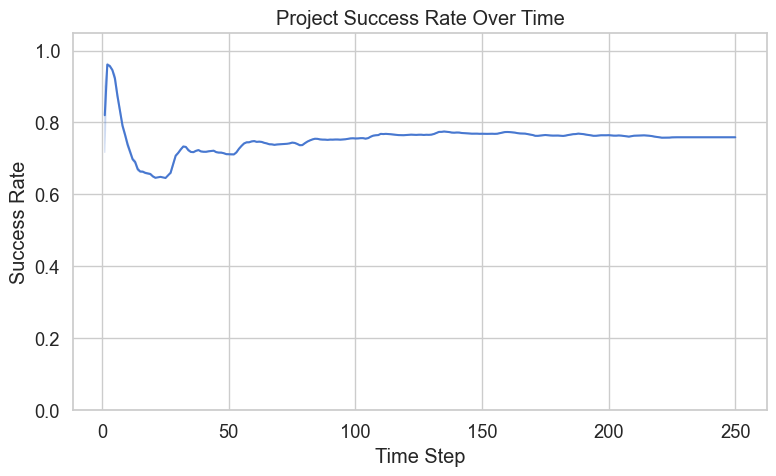

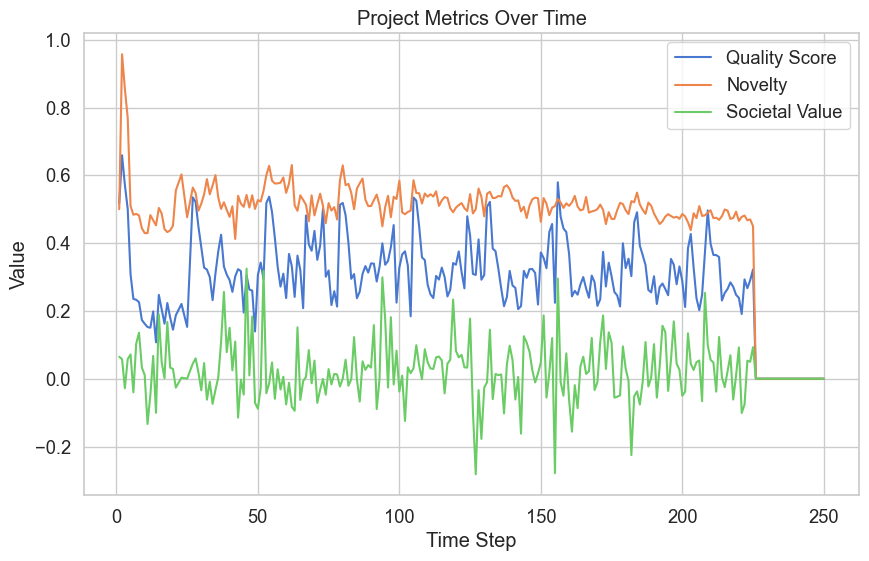

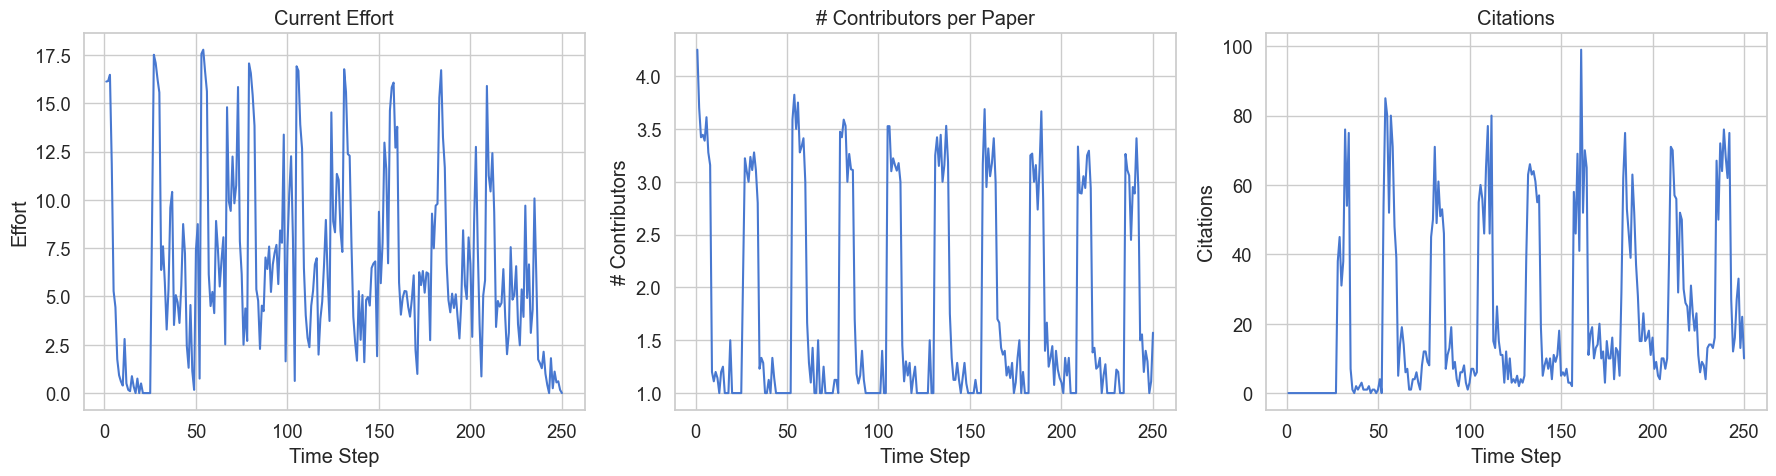

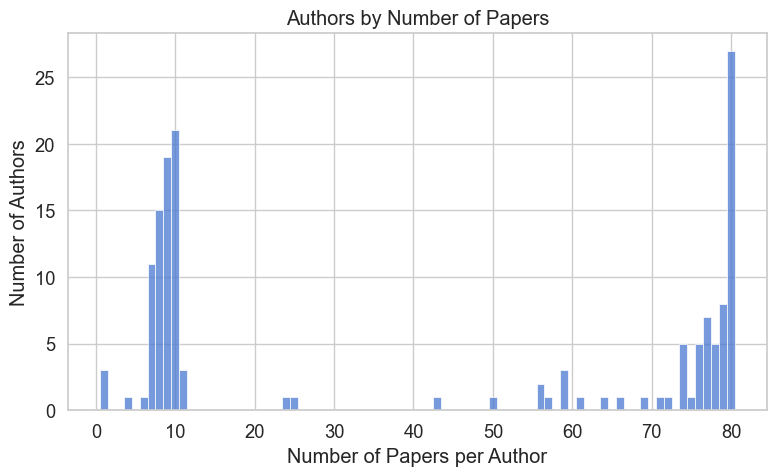

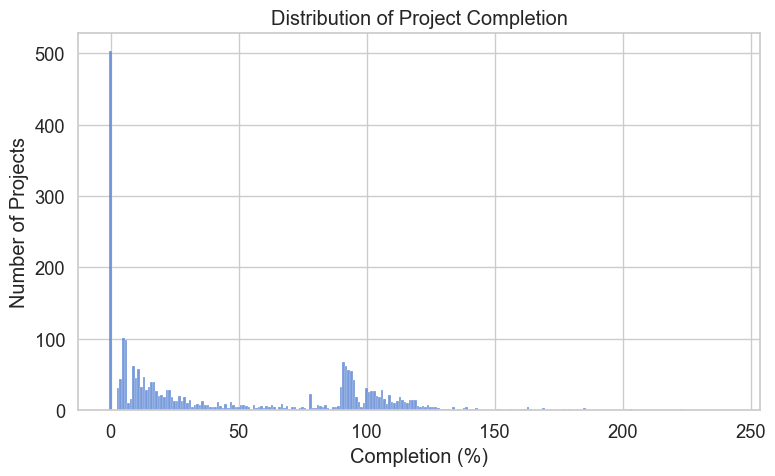

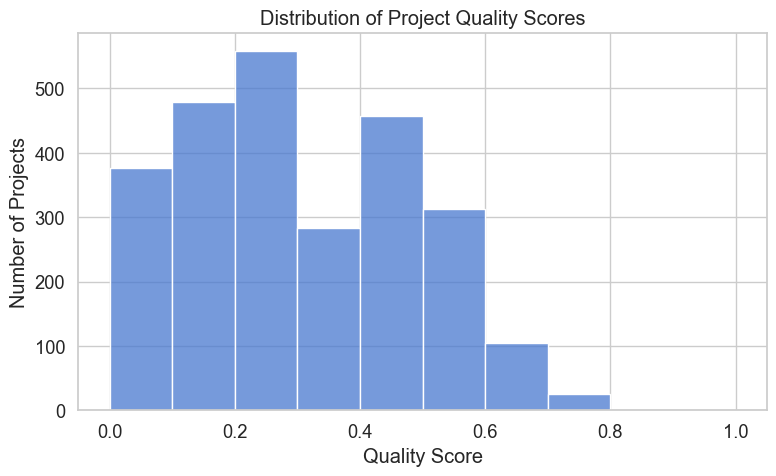

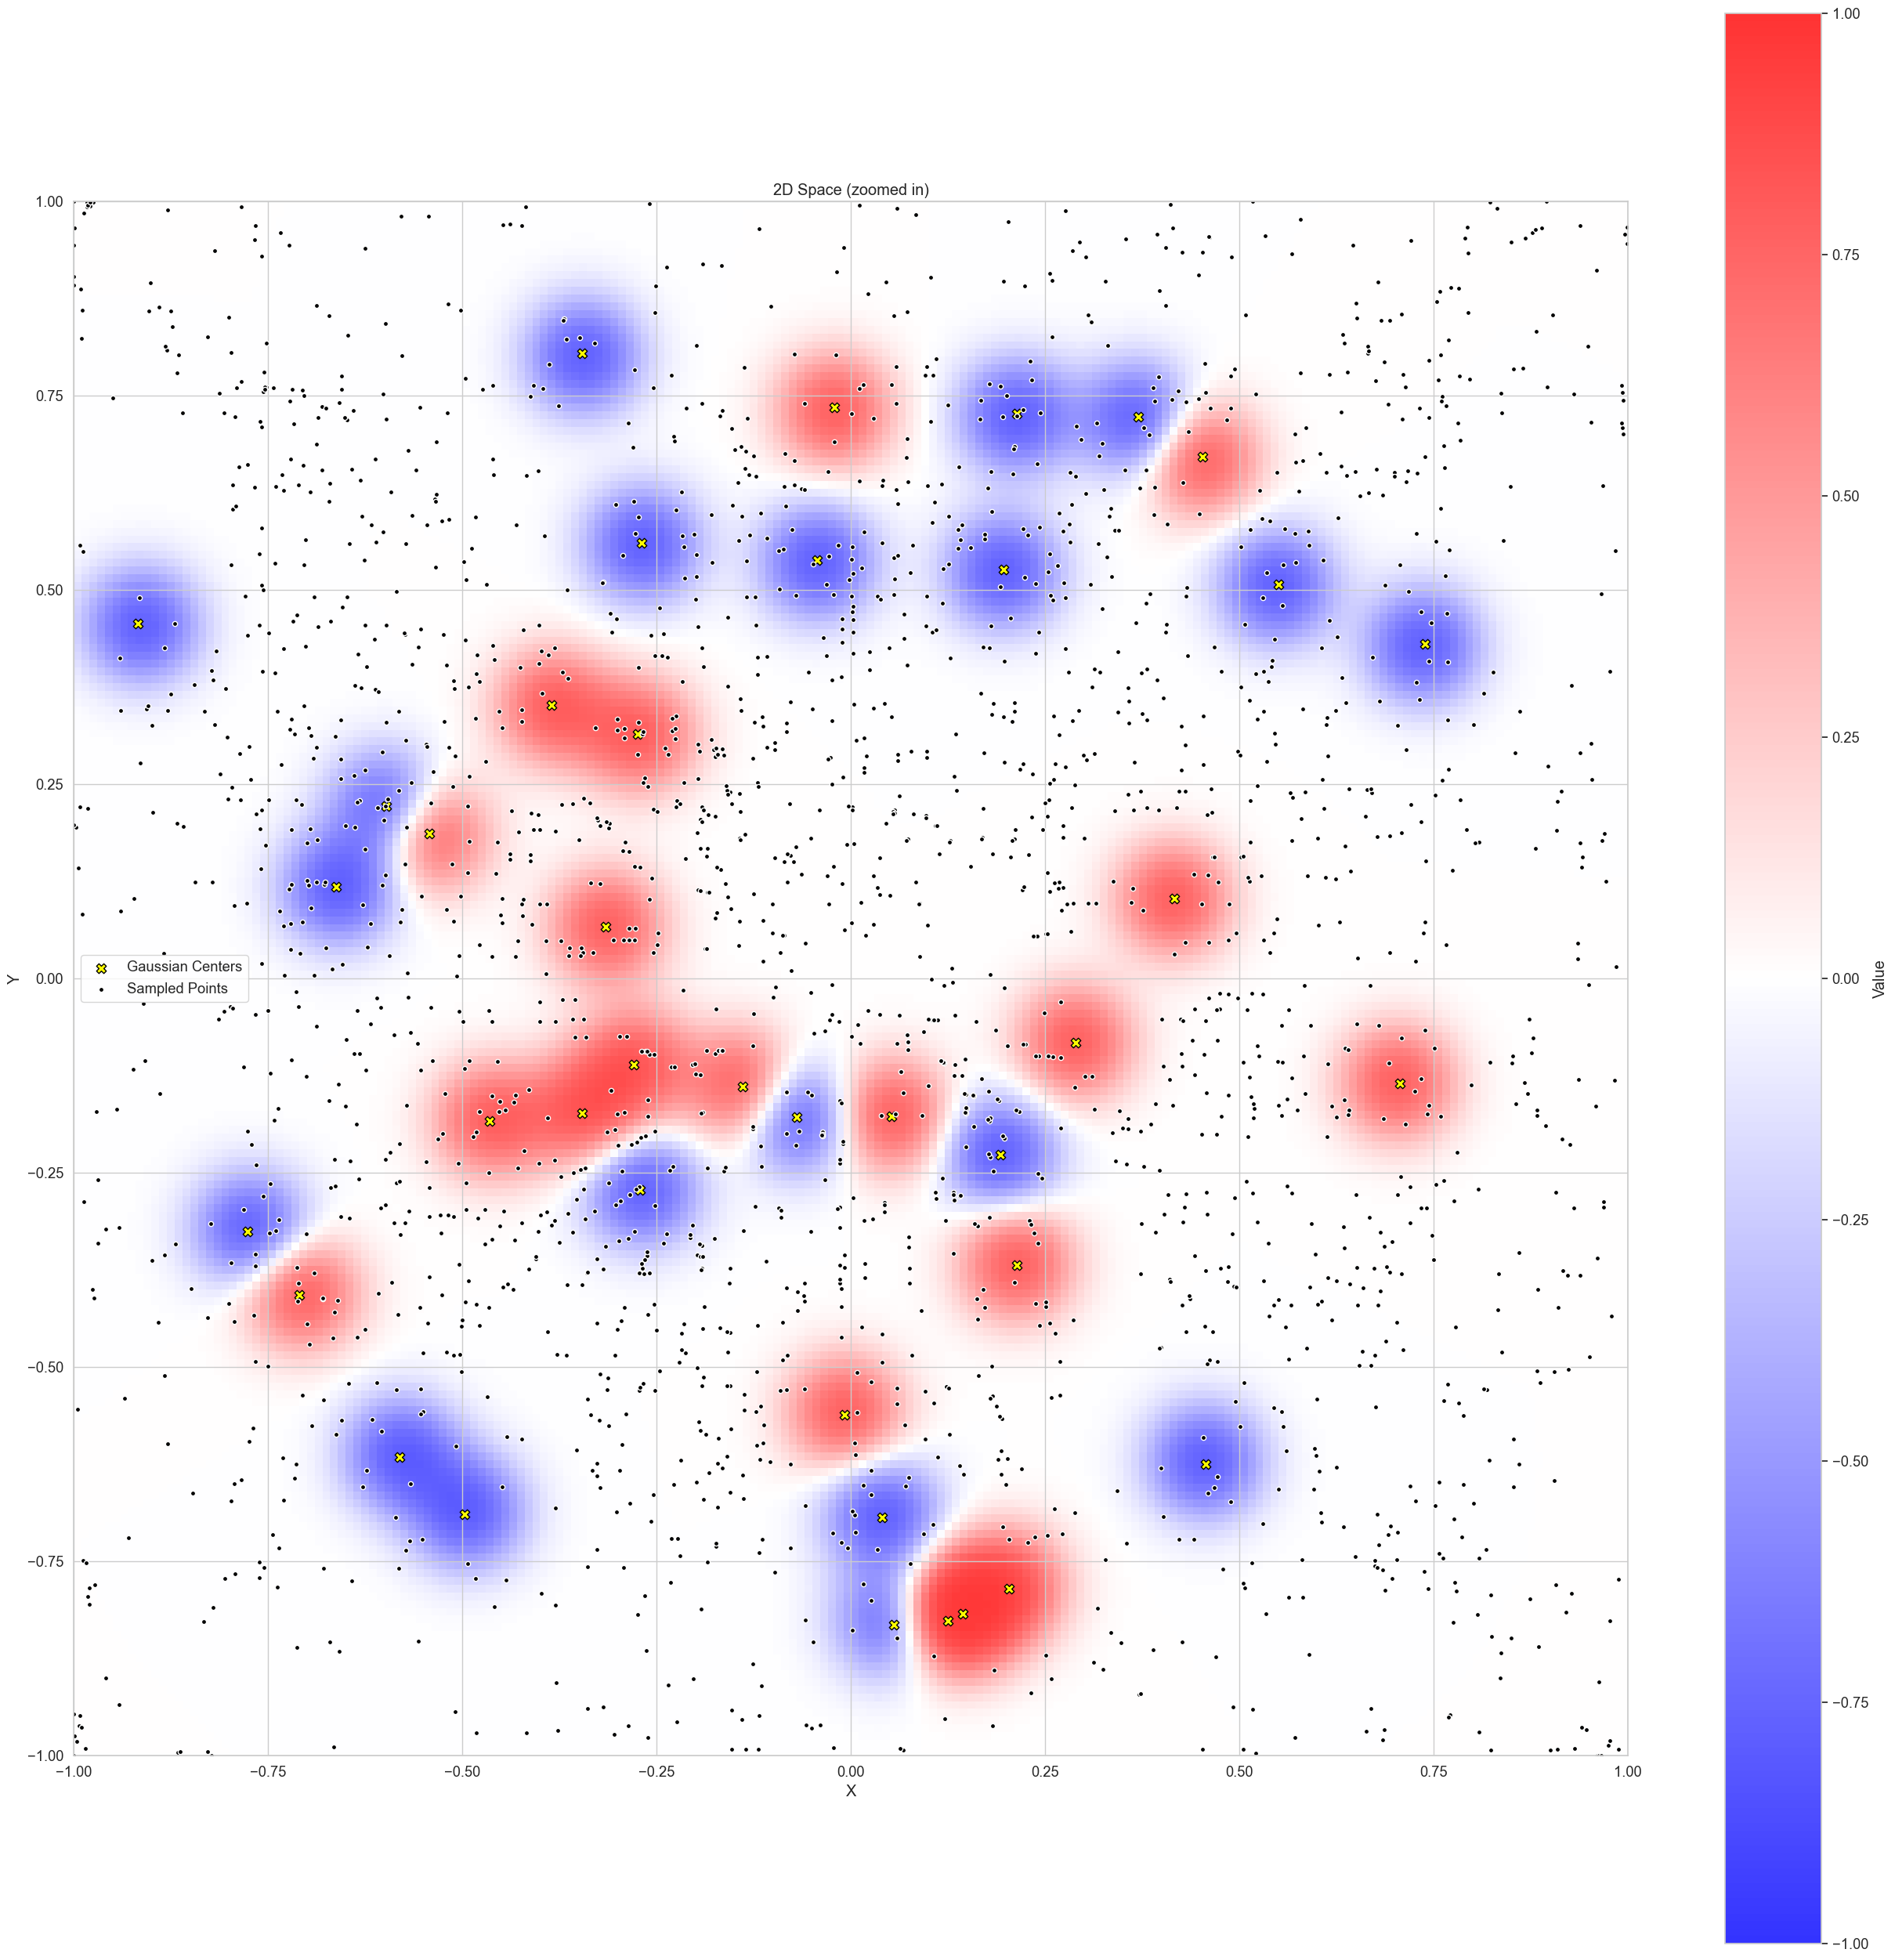

In [133]:
plot_histograms(balanced_projects, "../log/balanced_area.pickle")

In [83]:
# Load projects list from JSON file
with open("../log/policy_careerist_heavy_projects.json", "r") as f:
    careerist_heavy_projects = json.load(f)

In [ ]:
plot_histograms(careerist_heavy_projects, "../log/policy_careerist_heavy_area.pickle")

In [85]:
# Load projects list from JSON file
with open("../log/policy_orthodox_heavy_projects.json", "r") as f:
    orthodox_heavy_projects = json.load(f)

In [ ]:
plot_histograms(orthodox_heavy_projects, "../log/policy_orthodox_heavy_area.pickle")

In [48]:
# Load projects list from JSON file
with open("../log/debug_sim_projects.json", "r") as f:
   debug_projects = json.load(f)


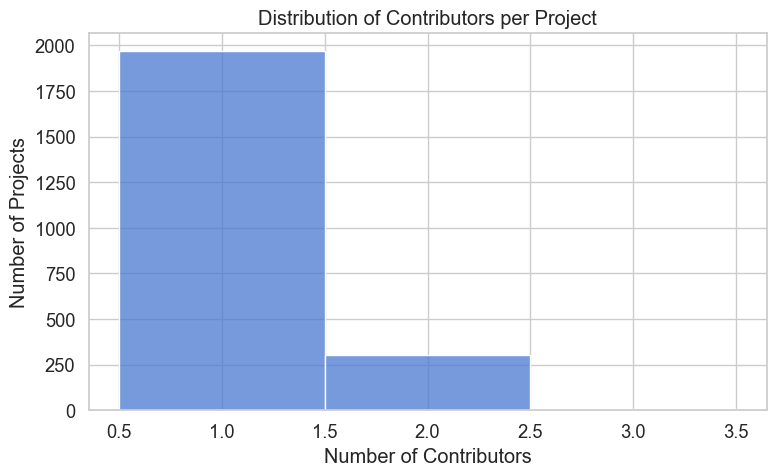

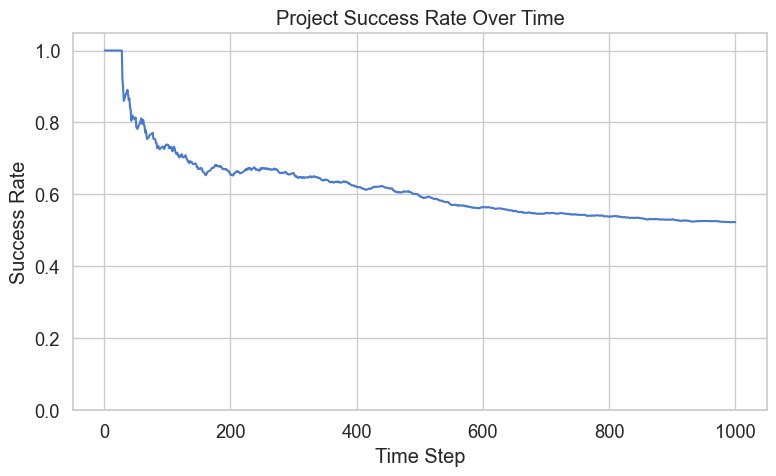

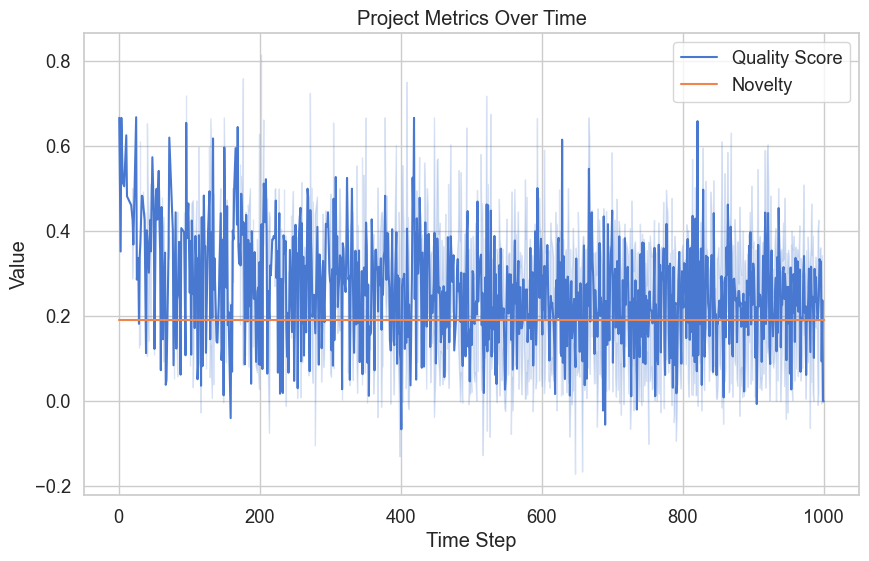

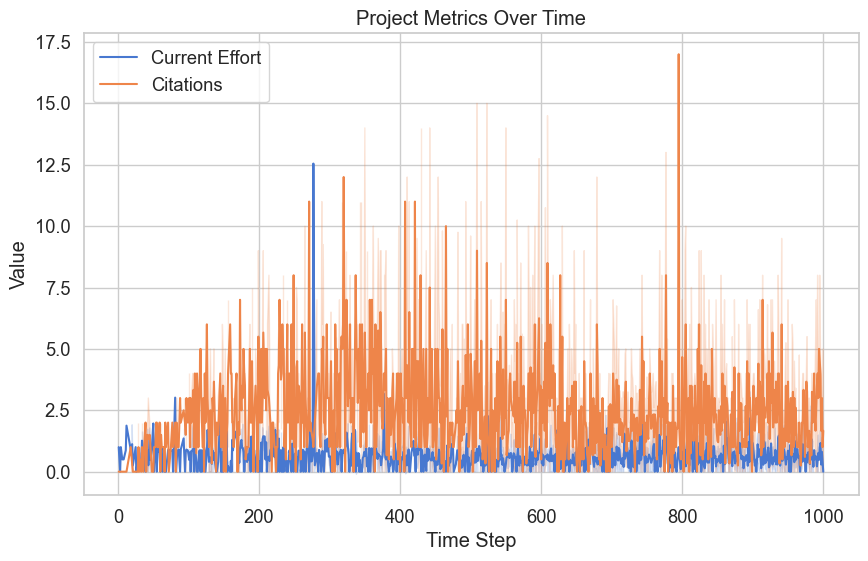

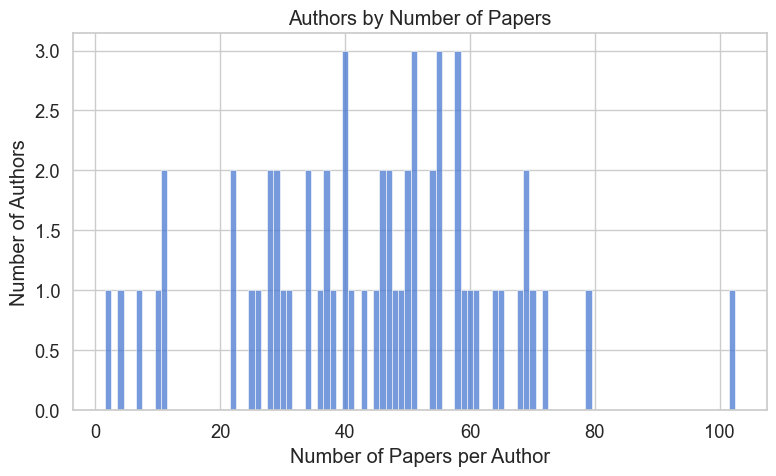

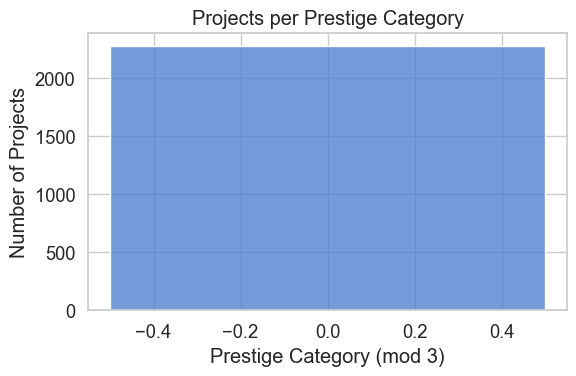

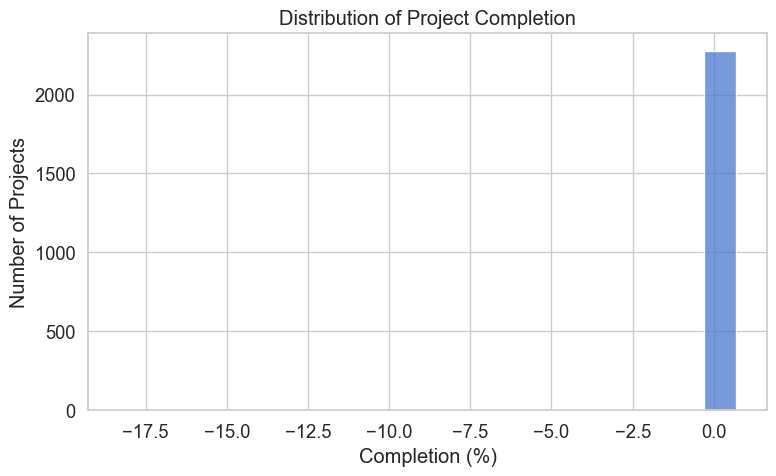

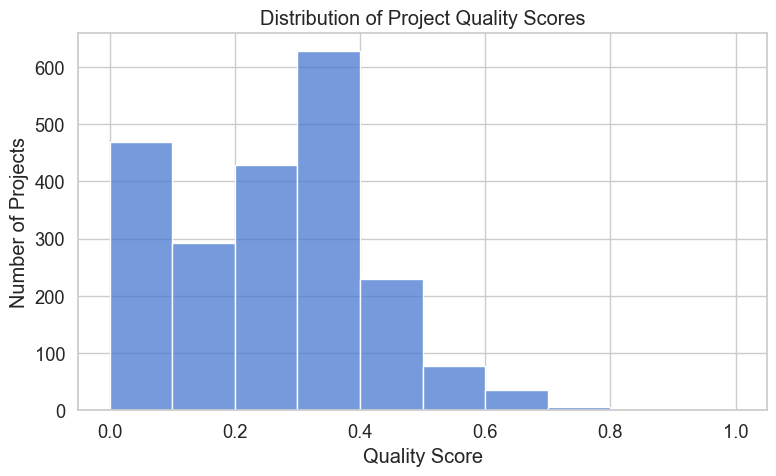

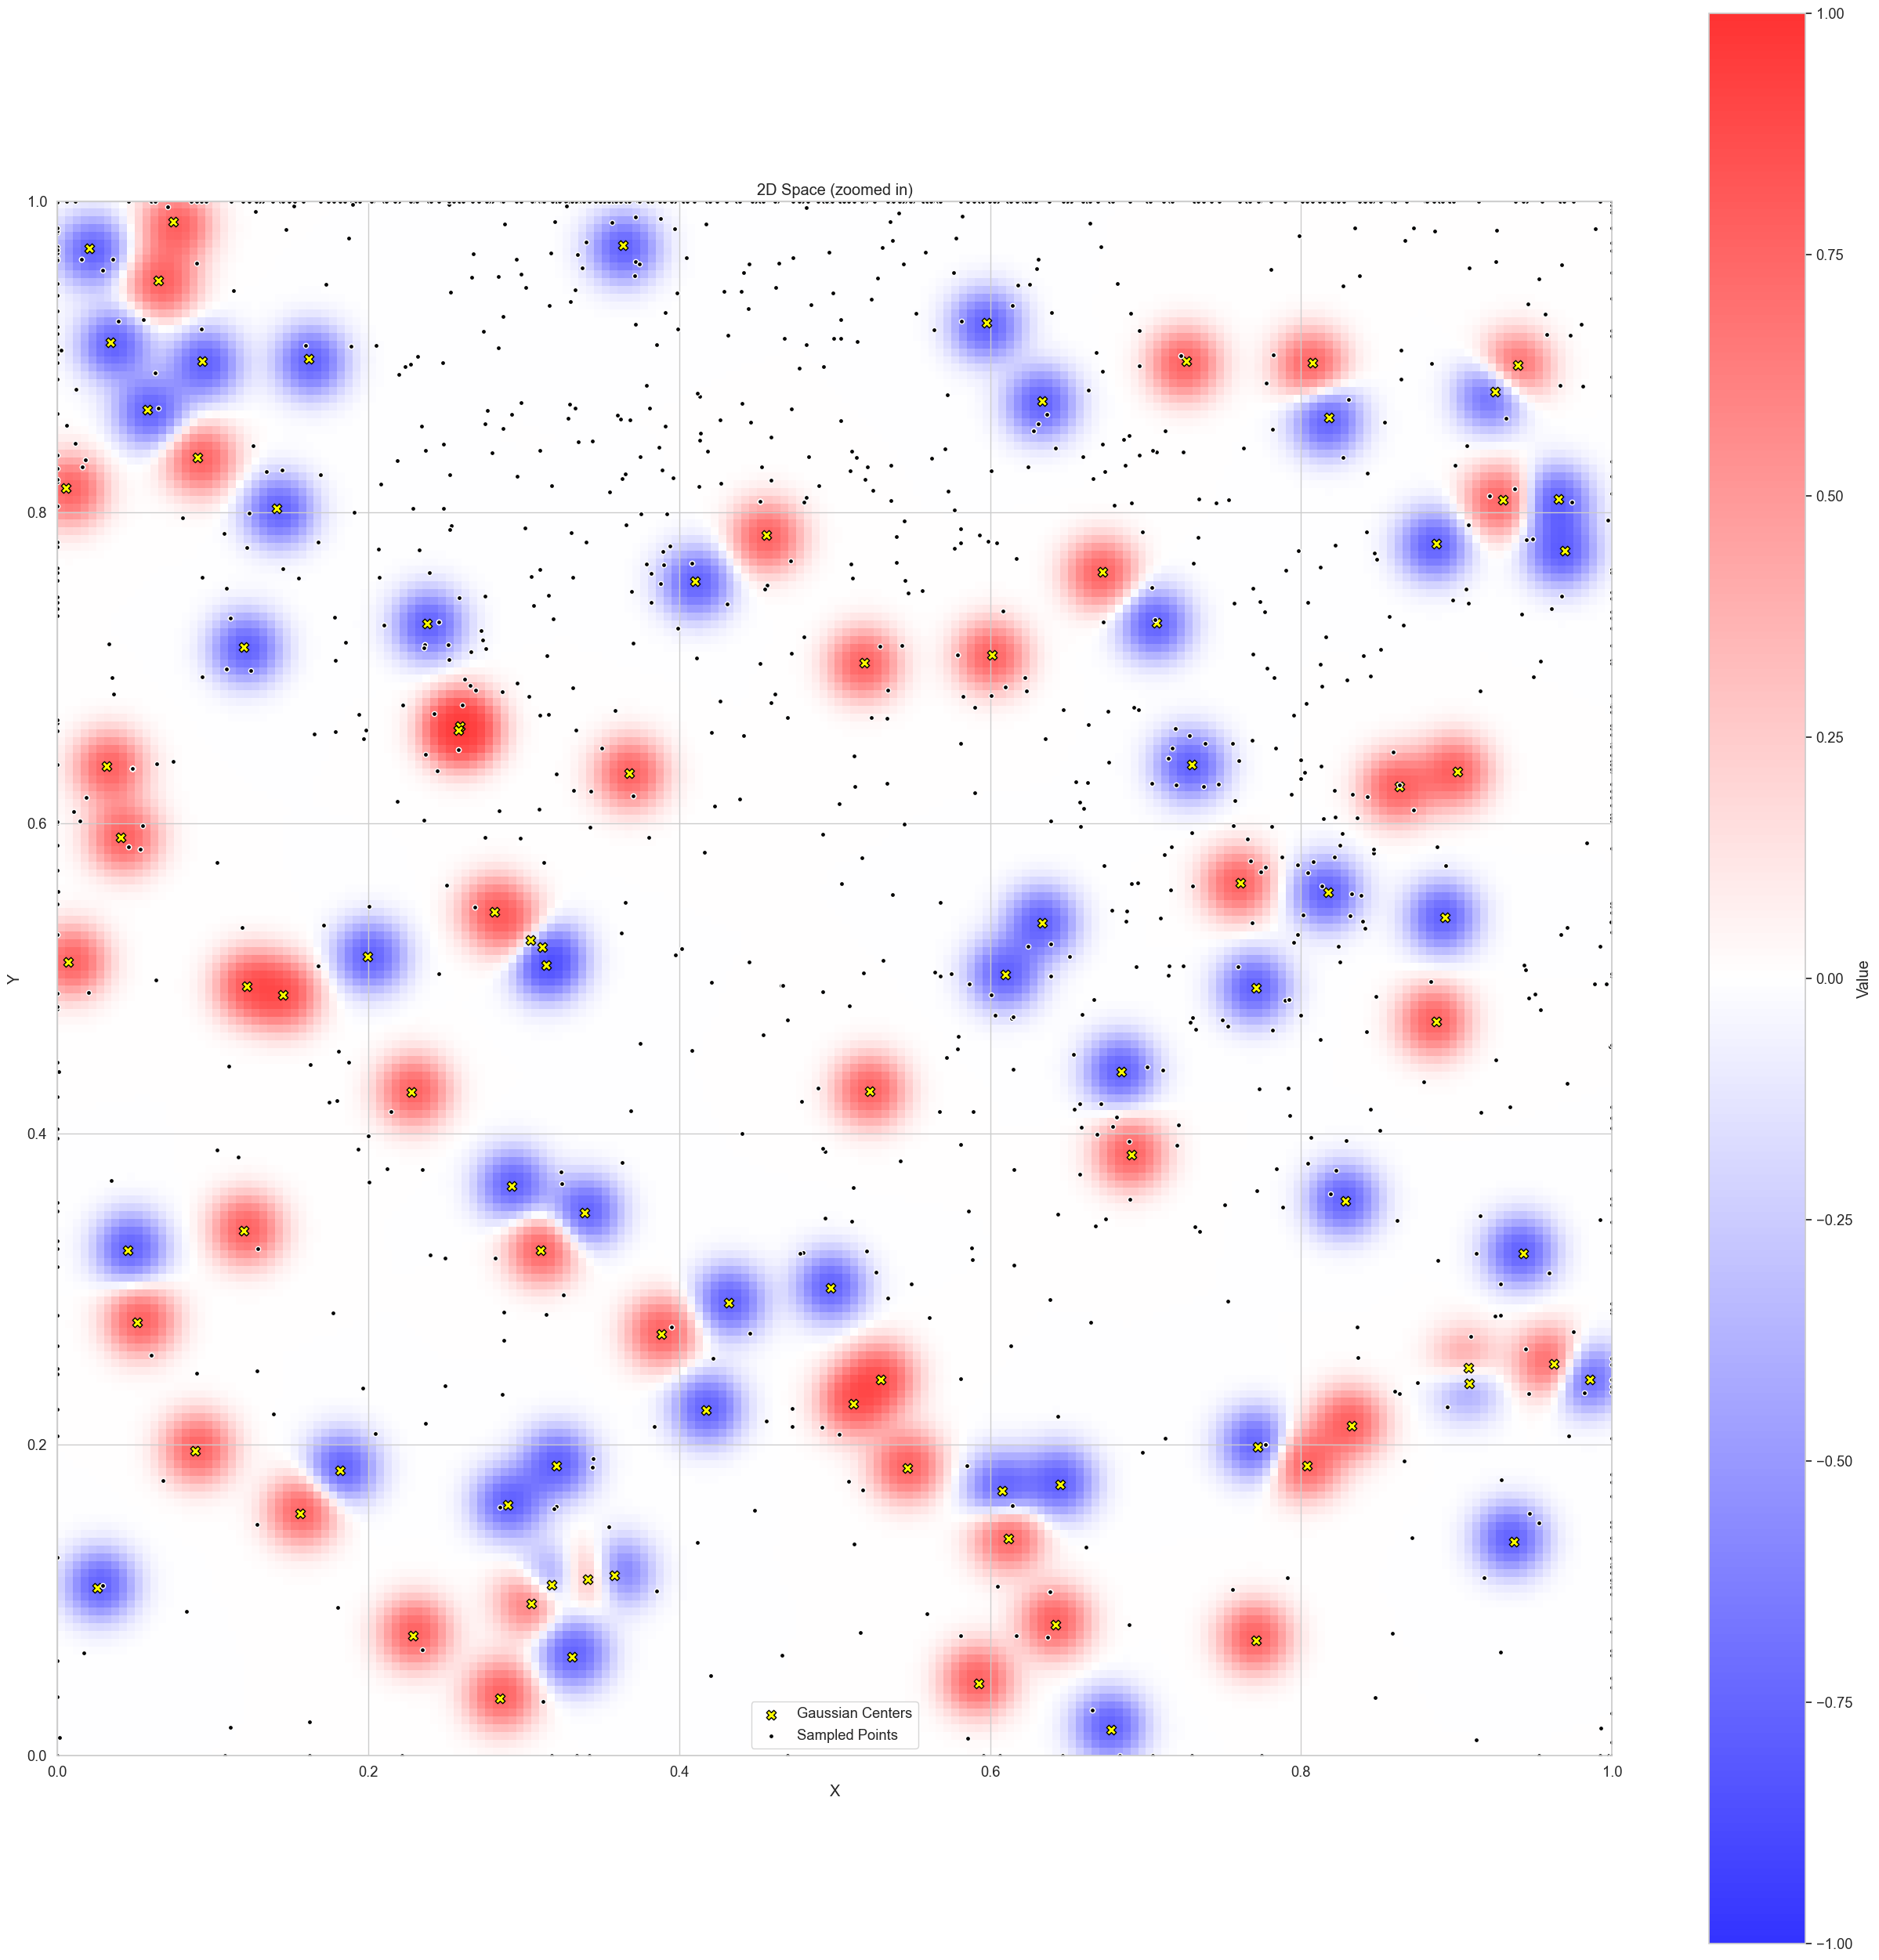

In [7]:
plot_histograms(debug_projects, "../log/debug_sim_actions.pickle")

In [89]:
# Load observations list from JSON file
debug_obs = []
with open("../log/debug_sim_observations.jsonl", "r") as f:
    for line in f.readlines():
        debug_obs.append(json.loads(line.strip()))

In [90]:
len(debug_obs)

2000

In [91]:
len([o for o in debug_obs[0] if o is not None])

100

In [92]:
debug_projects[0]

{'project_id': 'project_0-0-1',
 'required_effort': 9,
 'prestige': 0.6357000247046045,
 'time_window': 18.0,
 'peer_fit': [0.5],
 'novelty': 0.07366188122867724,
 'current_effort': 3.0,
 'contributors': [83],
 'start_time': 1,
 'finished': True,
 'final_reward': 0.6357000247046045,
 'kene': [-0.1648667394196213, 0.8356515056102948],
 'citations': [],
 'cited_by': ['project_1162-5-334', 'project_1162-5-334'],
 'generator_project_id': None,
 'validation_noise': 1.0640373313732217,
 'quality_score': 0.43386180003985036}